# Thử nghiệm: Gabor filtering + CNN + ViT + InceptionNet

# Preparation
Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import os
import shutil

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

## Data Path

Tải dữ liệu đã xử lý sẵn trên Google Drive

In [2]:
import os
project_dir = 'Project 1 - CV - Animal Image Classification/'
filter_path = project_dir + 'filtered-name/'
image_path = project_dir + 'animals/'
#os.makedirs(image_path, exist_ok=True)

In [3]:
folders = [f for f in os.listdir(filter_path) if os.path.isdir(os.path.join(filter_path, f))]
for folder in folders: print(folder, end = ' ')

seal armadillo otter opossum red_panda water_buffalo porcupine vampire_bat sugar_glider brown_bear mongoose dolphin weasel wildebeest sea_lion alpaca badger manatee koala mountain_goat vicuna warthog blue_whale tapir arctic_fox giraffe jackal orangutan groundhog baboon wombat yak african_elephant snow_leopard horse kangaroo squirrel polar_bear highland_cattle camel anteater american_bison rhinoceros walrus zebra 

In [4]:
for folder in folders:
  file_path = f'{filter_path}/{folder}/filtered-name.txt'

  with open(file_path, 'r') as file:
    for line in file:
      img = line.strip()
      path_img = f'{image_path}/{folder}/{img}'
      if os.path.exists(path_img):
        os.remove(path_img)
      else:
        print(f"{path_img} del-ed", end=" | ")

Project 1 - CV - Animal Image Classification/animals//seal/seal-0049.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0073.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0090.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0118.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0119.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0132.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0137.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0149.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0158.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0198.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0202.jpg del-ed | Project 1 - CV - Animal Image Classification/animals//seal/seal-0242.jpg del-ed | Project 1 - CV -

## Load data (with augmentation)

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

# Define the transformations for training and validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=image_path, transform=transform)

# Split dataset into training and validation sets
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

# Create subsets for training and validation
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)


# Model construction

## Helpers

In [6]:
import datetime

from matplotlib import pyplot as plt
import json

def plot_learning_curve(history_dict, name=''):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history_dict['train_loss'], label='Train Loss')
  plt.plot(history_dict['test_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history_dict['train_accuracy'], label='Train Accuracy')
  plt.plot(history_dict['test_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout()
  if name == '': name = datetime.datetime.now().strftime('%b-%d %H_%M_%S')
  plt.savefig(f'{name}')
  plt.show()

model_path = 'Project 1 - CV - Animal Image Classification/model and history'
def save_model(model, history_dict, name=''):
  if name == '': name = datetime.datetime.now().strftime('%b-%d %H_%M_%S')
  plot_learning_curve(history_dict, name)
  torch.save(model.state_dict(), f'{model_path}/{name}.pth')
  with open(f'{model_path}/history_{name}.json', 'w') as f:
    json.dump(history_dict, f)

## Model architecture

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.models import googlenet, efficientnet_b0
from torch.utils.data import DataLoader, Dataset
from vit_pytorch import ViT

### CNN Backbone
Combine of 2 models: EfficientNetB0 (Lightweight) and MobileNetV3 (super light)

In [9]:
import torch
import torch.nn as nn
class CNNBackbone(nn.Module):
    def __init__(self):
        super(CNNBackbone, self).__init__()
        self.efficientnet = efficientnet_b0(pretrained=True)
        self.inception = googlenet(pretrained=True)

    def forward(self, x):
        inception_out = self.inception(x)
        efficientnet_out = self.efficientnet(x)
        combined = torch.cat([inception_out, efficientnet_out], dim=1)
        return combined
 
class HybridModel(nn.Module):
    def __init__(self, num_classes=45):
        super(HybridModel, self).__init__()
        self.cnn_backbone = CNNBackbone()
        self.fc1 = nn.Linear(2000, 512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn_backbone(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training

## Helper

In [11]:
import wandb
wandb.login()
wandb.init(project="HybridModel-AnimalsClassifier", entity="letangphuquy4-vietnam-korea-university-of-information-an")  # Replace "your_wandb_username" with your actual wandb username
wandb.config.update({"epochs": 30, "batch_size": 128,
                    "num_classes": 45, "img_size": 224})


wandb: Currently logged in as: letangphuquy4 (letangphuquy4-vietnam-korea-university-of-information-an). Use `wandb login --relogin` to force relogin


wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Tracking run with wandb version 0.17.7


wandb: Run data is saved locally in /home/ltpq/ai4e/CV_1/wandb/run-20240902_140027-4jrn2m6q
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run clean-leaf-14


wandb: ⭐️ View project at https://wandb.ai/letangphuquy4-vietnam-korea-university-of-information-an/HybridModel-AnimalsClassifier


wandb: 🚀 View run at https://wandb.ai/letangphuquy4-vietnam-korea-university-of-information-an/HybridModel-AnimalsClassifier/runs/4jrn2m6q


In [12]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

## Train

In [13]:
model = HybridModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.7)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'train_accuracy': [],
    'test_accuracy': []
}

# Training with frozen layers
num_epochs_frozen = 50

for epoch in range(num_epochs_frozen):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs_frozen} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs_frozen} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy,
                "test_loss": test_loss, "test_accuracy": test_accuracy})

/home/ltpq/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ltpq/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/ltpq/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 - Train Loss: 3.3962, Train Accuracy: 0.1962
Epoch 1/50 - Test Loss: 2.8642, Test Accuracy: 0.4590


Epoch 2/50 - Train Loss: 2.4732, Train Accuracy: 0.5093
Epoch 2/50 - Test Loss: 2.0142, Test Accuracy: 0.6449


Epoch 3/50 - Train Loss: 1.7917, Train Accuracy: 0.6437
Epoch 3/50 - Test Loss: 1.4927, Test Accuracy: 0.7253


Epoch 4/50 - Train Loss: 1.3766, Train Accuracy: 0.7184
Epoch 4/50 - Test Loss: 1.1819, Test Accuracy: 0.7737


Epoch 5/50 - Train Loss: 1.1163, Train Accuracy: 0.7607
Epoch 5/50 - Test Loss: 0.9642, Test Accuracy: 0.8053


Epoch 6/50 - Train Loss: 0.9606, Train Accuracy: 0.7834
Epoch 6/50 - Test Loss: 0.8372, Test Accuracy: 0.8225


Epoch 7/50 - Train Loss: 0.8347, Train Accuracy: 0.8109
Epoch 7/50 - Test Loss: 0.7462, Test Accuracy: 0.8357


Epoch 8/50 - Train Loss: 0.7534, Train Accuracy: 0.8202
Epoch 8/50 - Test Loss: 0.6805, Test Accuracy: 0.8469


Epoch 9/50 - Train Loss: 0.6814, Train Accuracy: 0.8359
Epoch 9/50 - Test Loss: 0.6350, Test Accuracy: 0.8525


Epoch 10/50 - Train Loss: 0.6266, Train Accuracy: 0.8458
Epoch 10/50 - Test Loss: 0.5990, Test Accuracy: 0.8481


Epoch 11/50 - Train Loss: 0.5848, Train Accuracy: 0.8534
Epoch 11/50 - Test Loss: 0.5609, Test Accuracy: 0.8645


Epoch 12/50 - Train Loss: 0.5548, Train Accuracy: 0.8603
Epoch 12/50 - Test Loss: 0.5123, Test Accuracy: 0.8685


Epoch 13/50 - Train Loss: 0.5228, Train Accuracy: 0.8665
Epoch 13/50 - Test Loss: 0.5183, Test Accuracy: 0.8673


Epoch 14/50 - Train Loss: 0.4978, Train Accuracy: 0.8722
Epoch 14/50 - Test Loss: 0.4891, Test Accuracy: 0.8717


Epoch 15/50 - Train Loss: 0.4764, Train Accuracy: 0.8745
Epoch 15/50 - Test Loss: 0.4644, Test Accuracy: 0.8804


Epoch 16/50 - Train Loss: 0.4523, Train Accuracy: 0.8802
Epoch 16/50 - Test Loss: 0.4535, Test Accuracy: 0.8800


Epoch 17/50 - Train Loss: 0.4305, Train Accuracy: 0.8867
Epoch 17/50 - Test Loss: 0.4430, Test Accuracy: 0.8828


Epoch 18/50 - Train Loss: 0.4235, Train Accuracy: 0.8870
Epoch 18/50 - Test Loss: 0.4245, Test Accuracy: 0.8892


Epoch 19/50 - Train Loss: 0.4162, Train Accuracy: 0.8883
Epoch 19/50 - Test Loss: 0.4215, Test Accuracy: 0.8908


Epoch 20/50 - Train Loss: 0.3920, Train Accuracy: 0.8957
Epoch 20/50 - Test Loss: 0.4054, Test Accuracy: 0.8900


Epoch 21/50 - Train Loss: 0.3741, Train Accuracy: 0.8946
Epoch 21/50 - Test Loss: 0.4082, Test Accuracy: 0.8896


Epoch 22/50 - Train Loss: 0.3677, Train Accuracy: 0.8998
Epoch 22/50 - Test Loss: 0.3843, Test Accuracy: 0.8928


Epoch 23/50 - Train Loss: 0.3527, Train Accuracy: 0.9011
Epoch 23/50 - Test Loss: 0.3760, Test Accuracy: 0.8996


Epoch 24/50 - Train Loss: 0.3517, Train Accuracy: 0.9032
Epoch 24/50 - Test Loss: 0.3953, Test Accuracy: 0.8884


Epoch 25/50 - Train Loss: 0.3358, Train Accuracy: 0.9063
Epoch 25/50 - Test Loss: 0.3569, Test Accuracy: 0.8980


Epoch 26/50 - Train Loss: 0.3307, Train Accuracy: 0.9097
Epoch 26/50 - Test Loss: 0.3705, Test Accuracy: 0.8936


Epoch 27/50 - Train Loss: 0.3182, Train Accuracy: 0.9169
Epoch 27/50 - Test Loss: 0.3644, Test Accuracy: 0.8948


Epoch 28/50 - Train Loss: 0.3123, Train Accuracy: 0.9121
Epoch 28/50 - Test Loss: 0.3500, Test Accuracy: 0.8972


Epoch 29/50 - Train Loss: 0.2991, Train Accuracy: 0.9170
Epoch 29/50 - Test Loss: 0.3433, Test Accuracy: 0.9040


Epoch 30/50 - Train Loss: 0.2879, Train Accuracy: 0.9194
Epoch 30/50 - Test Loss: 0.3497, Test Accuracy: 0.9004


Epoch 31/50 - Train Loss: 0.2814, Train Accuracy: 0.9230
Epoch 31/50 - Test Loss: 0.3485, Test Accuracy: 0.8984


Epoch 32/50 - Train Loss: 0.2758, Train Accuracy: 0.9245
Epoch 32/50 - Test Loss: 0.3411, Test Accuracy: 0.9008


Epoch 33/50 - Train Loss: 0.2740, Train Accuracy: 0.9228
Epoch 33/50 - Test Loss: 0.3379, Test Accuracy: 0.8992


Epoch 34/50 - Train Loss: 0.2689, Train Accuracy: 0.9253
Epoch 34/50 - Test Loss: 0.3370, Test Accuracy: 0.9000


Epoch 35/50 - Train Loss: 0.2698, Train Accuracy: 0.9238
Epoch 35/50 - Test Loss: 0.3331, Test Accuracy: 0.9036


Epoch 36/50 - Train Loss: 0.2637, Train Accuracy: 0.9272
Epoch 36/50 - Test Loss: 0.3234, Test Accuracy: 0.9088


Epoch 37/50 - Train Loss: 0.2590, Train Accuracy: 0.9275
Epoch 37/50 - Test Loss: 0.3372, Test Accuracy: 0.9004


Epoch 38/50 - Train Loss: 0.2537, Train Accuracy: 0.9276
Epoch 38/50 - Test Loss: 0.3209, Test Accuracy: 0.9060


Epoch 39/50 - Train Loss: 0.2491, Train Accuracy: 0.9312
Epoch 39/50 - Test Loss: 0.3181, Test Accuracy: 0.9084


Epoch 40/50 - Train Loss: 0.2336, Train Accuracy: 0.9337
Epoch 40/50 - Test Loss: 0.3138, Test Accuracy: 0.9060


Epoch 41/50 - Train Loss: 0.2352, Train Accuracy: 0.9354
Epoch 41/50 - Test Loss: 0.3241, Test Accuracy: 0.9072


Epoch 42/50 - Train Loss: 0.2281, Train Accuracy: 0.9390
Epoch 42/50 - Test Loss: 0.3089, Test Accuracy: 0.9100


Epoch 43/50 - Train Loss: 0.2256, Train Accuracy: 0.9366
Epoch 43/50 - Test Loss: 0.3202, Test Accuracy: 0.9028


Epoch 44/50 - Train Loss: 0.2271, Train Accuracy: 0.9319
Epoch 44/50 - Test Loss: 0.3097, Test Accuracy: 0.9116


Epoch 45/50 - Train Loss: 0.2280, Train Accuracy: 0.9357
Epoch 45/50 - Test Loss: 0.2974, Test Accuracy: 0.9084


Epoch 46/50 - Train Loss: 0.2167, Train Accuracy: 0.9381
Epoch 46/50 - Test Loss: 0.2939, Test Accuracy: 0.9108


Epoch 47/50 - Train Loss: 0.2071, Train Accuracy: 0.9426
Epoch 47/50 - Test Loss: 0.2930, Test Accuracy: 0.9168


Epoch 48/50 - Train Loss: 0.2107, Train Accuracy: 0.9386
Epoch 48/50 - Test Loss: 0.3038, Test Accuracy: 0.9076


Epoch 49/50 - Train Loss: 0.2089, Train Accuracy: 0.9405
Epoch 49/50 - Test Loss: 0.2977, Test Accuracy: 0.9108


Epoch 50/50 - Train Loss: 0.2023, Train Accuracy: 0.9451
Epoch 50/50 - Test Loss: 0.2969, Test Accuracy: 0.9108


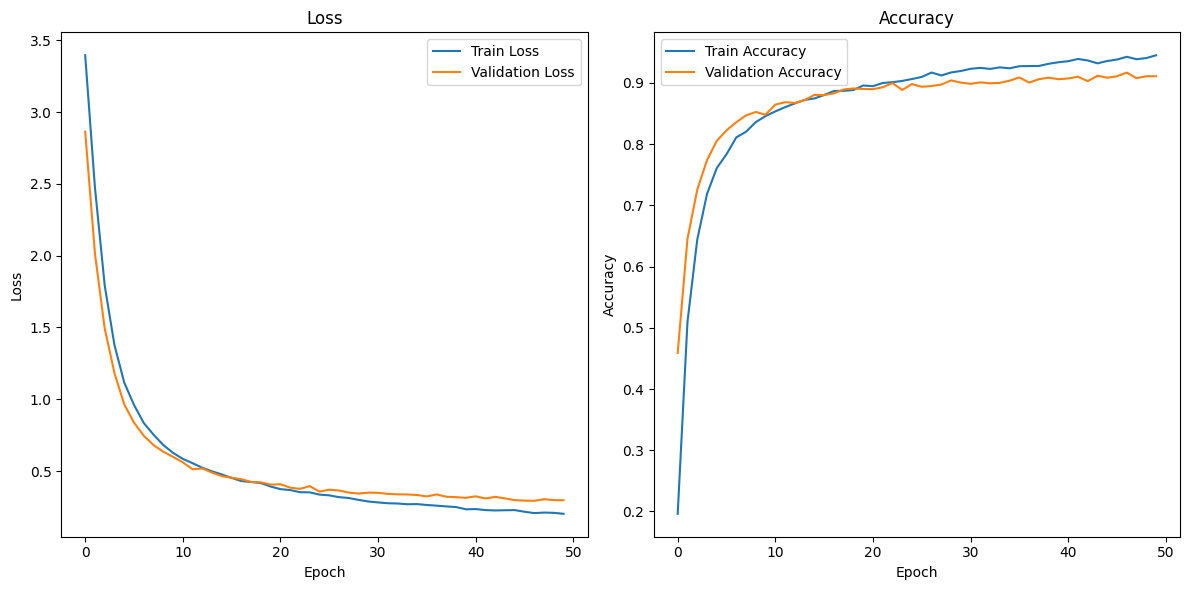

In [14]:
save_model(model, history, "hybrid_model")

In [15]:
wandb.finish()

wandb:                                                                                


wandb: 
wandb: Run history:
wandb:  test_accuracy ▁▄▅▆▇▇▇▇▇▇▇▇▇▇██████████████████████████
wandb:      test_loss █▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: train_accuracy ▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
wandb:     train_loss █▆▄▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:  test_accuracy 0.91084
wandb:      test_loss 0.29691
wandb: train_accuracy 0.94511
wandb:     train_loss 0.20232
wandb: 


wandb: 🚀 View run clean-leaf-14 at: https://wandb.ai/letangphuquy4-vietnam-korea-university-of-information-an/HybridModel-AnimalsClassifier/runs/4jrn2m6q
wandb: ⭐️ View project at: https://wandb.ai/letangphuquy4-vietnam-korea-university-of-information-an/HybridModel-AnimalsClassifier
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)


wandb: Find logs at: ./wandb/run-20240902_140027-4jrn2m6q/logs


wandb: WARNING The new W&B backend becomes opt-out in version 0.18.0; try it out with `wandb.require("core")`! See https://wandb.me/wandb-core for more information.
